In [1]:
%pylab inline
from astropy.table import Table
from rnn import RNNClassifier
import tensorflow as tf
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Loading dataset
data_table = Table.read('normalized_sub_mean.fits')
#data_table = Table.read('normalized_good.fits')

In [3]:
data_table

FILENAME,SURVEY,SNID,SNTYPE,FILTERS,RA,DECL,FAKE,MWEBV,REDSHIFT_SPE,NOBS,NVAR,"DATA [50,9]",obs_length,num_data_points
bytes16,bytes7,bytes12,bytes5,bytes6,bytes21,bytes20,bytes35,bytes23,bytes25,bytes5,bytes3,float64,float64,int64
DES_SN000018.DAT,DES,18,-9,griz,34.500000 deg,-5.500000 deg,3 (=> BLIND-TEST simulation),0.0227 MW E(B-V),-9.0000 +- 9.0000,118,5,0.0 .. 0.0,145.8949999999968,41
DES_SN000050.DAT,DES,50,-9,griz,36.750000 deg,-4.500000 deg,3 (=> BLIND-TEST simulation),0.0283 MW E(B-V),-9.0000 +- 9.0000,16,5,0.0 .. 0.0,30.93000000000029,9
DES_SN000051.DAT,DES,51,1,griz,52.500000 deg,-27.500000 deg,3 (=> BLIND-TEST simulation),0.0097 MW E(B-V),0.5177 +- 0.0050,121,5,0.0 .. 0.0,126.88300000000163,33
DES_SN000063.DAT,DES,63,-9,griz,34.500000 deg,-5.500000 deg,3 (=> BLIND-TEST simulation),0.0227 MW E(B-V),-9.0000 +- 9.0000,115,5,0.0 .. 0.0,127.9409999999989,37
DES_SN000064.DAT,DES,64,-9,griz,48.000000 deg,0.000000 deg,3 (=> BLIND-TEST simulation),0.0713 MW E(B-V),-9.0000 +- 9.0000,92,5,0.0 .. 0.0,117.89800000000105,31
DES_SN000096.DAT,DES,96,-9,griz,34.500000 deg,-5.500000 deg,3 (=> BLIND-TEST simulation),0.0227 MW E(B-V),-9.0000 +- 9.0000,104,5,0.0 .. 0.0,119.87900000000081,37
DES_SN000122.DAT,DES,122,-9,griz,34.500000 deg,-5.500000 deg,3 (=> BLIND-TEST simulation),0.0227 MW E(B-V),-9.0000 +- 9.0000,11,5,0.0 .. 0.0,17.95300000000134,7
DES_SN000124.DAT,DES,124,-9,griz,48.000000 deg,0.000000 deg,3 (=> BLIND-TEST simulation),0.0713 MW E(B-V),-9.0000 +- 9.0000,95,5,0.0 .. 0.0,113.96500000000378,34
DES_SN000156.DAT,DES,156,-9,griz,36.750000 deg,-4.500000 deg,3 (=> BLIND-TEST simulation),0.0283 MW E(B-V),-9.0000 +- 9.0000,87,5,0.0 .. 0.0,96.0309999999954,25


In [4]:
# Splitting training and testing data
np.random.seed(1234)
randomize_inds = range(len(data_table))
randomize_inds = permutation(randomize_inds)
randomized_inds_train = randomize_inds[0:15000]
randomized_inds_test  = randomize_inds[15000:]

In [5]:
data_table['label'] = 1.0*(data_table['SNTYPE'].astype('int') == 1)

In [6]:
# Define input function for training 
def input_fn_train():
    def mapping_function(x):
        def extract_batch(inds):
            inds = randomized_inds_train[inds]
            return data_table['label'][inds].astype('float32'), clip(data_table['num_data_points'][inds],0,49).astype('int32'),data_table['DATA'][inds].astype('float32') 
        a,b,c =tf.py_func( extract_batch, [x], [tf.float32, tf.int32, tf.float32])
        a.set_shape([None])
        b.set_shape([None])
        c.set_shape([None,50,9])
        return a,b,c

    dataset = tf.data.Dataset.range(len(randomized_inds_train))
    dataset = dataset.repeat().shuffle(10000).batch(512)
    dataset = dataset.map( mapping_function)
    iterator = dataset.make_one_shot_iterator()
    label, length, ts = iterator.get_next()
    return  {'length':length, 'ts':ts}, label

def input_fn_train_test():
    def mapping_function(x):
        def extract_batch(inds):
            inds = randomized_inds_train[inds]
            return data_table['label'][inds].astype('float32'), clip(data_table['num_data_points'][inds],0,49).astype('int32'),data_table['DATA'][inds].astype('float32')
        a,b,c =tf.py_func( extract_batch, [x], [tf.float32, tf.int32, tf.float32])
        a.set_shape([None])
        b.set_shape([None])
        c.set_shape([None,50,9])
        return a,b,c

    dataset = tf.data.Dataset.range(len(randomized_inds_train))
    dataset = dataset.batch(512)
    dataset = dataset.map( mapping_function)
    iterator = dataset.make_one_shot_iterator()
    label, length, ts = iterator.get_next()
    return  {'length':length, 'ts':ts}, label

def input_fn_test():
    def mapping_function(x):
        def extract_batch(inds):
            inds = randomized_inds_test[inds]
            return data_table['label'][inds].astype('float32'), clip(data_table['num_data_points'][inds],0,49).astype('int32'),data_table['DATA'][inds].astype('float32') 
        a,b,c =tf.py_func( extract_batch, [x], [tf.float32, tf.int32, tf.float32])
        a.set_shape([None])
        b.set_shape([None])
        c.set_shape([None,50,9])
        return a,b,c

    dataset = tf.data.Dataset.range(len(randomized_inds_test))
    dataset = dataset.batch(512)
    dataset = dataset.map( mapping_function)
    iterator = dataset.make_one_shot_iterator()
    label, length, ts = iterator.get_next()
    return  {'length':length, 'ts':ts}, label

In [7]:
#model = RNNClassifier(hidden_units=[128, 128], dropout=1, model_dir='tests/test_1')
#model = RNNClassifier(hidden_units=[128, 128], dropout=0.8, model_dir='tests/test_2')
#model = RNNClassifier(hidden_units=[128, 128], dropout=0.8, model_dir='tests/test_5')
#model = RNNClassifier(hidden_units=[128, 128], dropout=0.8, model_dir='tests/test_6')
model = RNNClassifier(hidden_units=[128, 128], dropout=0.8, model_dir='tests/test_10')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'tests/test_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x121eee2e8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [8]:
#model.train(input_fn=input_fn_train, steps=10000)

In [9]:
# Apply model to test set
test_prob = [p['prob'] for p in model.predict(input_fn_test)]
table_test = data_table[randomized_inds_test]
table_test['p'] = test_prob

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tests/test_10/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [10]:
# Apply model to training set
train_prob = [p['prob'] for p in model.predict(input_fn_train_test)]
table_train = data_table[randomized_inds_train]
table_train['p'] = train_prob

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tests/test_10/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [ ]:
hist(test_prob, 100);
hist(train_prob,100);

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(0, 1)

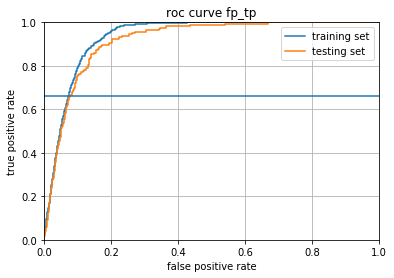

In [11]:
# Compute ROC curves 
from sklearn.metrics import roc_curve

fpr1, tpr1, thr1 = roc_curve(table_train['label'], table_train['p'])
fpr2, tpr2, thr2 = roc_curve(table_test['label'], table_test['p'])

plot(fpr1, tpr1,label='training set')
plot(fpr2, tpr2,label='testing set')
title("roc curve fp_tp")
xlabel('false positive rate')
ylabel('true positive rate')
grid('on')
#xscale('log')
legend()
axhline(0.661)
xlim(0,1)
ylim(0,1)

In [12]:
from sklearn.metrics import roc_auc_score

In [13]:
roc_auc_score(table_train['label'], table_train['p'])

0.9342636756280795

In [14]:
roc_auc_score(table_test['label'], table_test['p'])

0.9173094870769289

In [15]:
# Compute Confusion Matrix
from sklearn.metrics import confusion_matrix

threshold=0.083

actual = table_test['label']
predict = table_test['p'] > threshold

confusion_matrix(actual, predict)

array([[2740,  442],
       [  27,  138]])

In [16]:
FP = (table_test['p'] > threshold) * (table_test['label'] == 0)
TP = (table_test['p'] > threshold) * (table_test['label'] == 1)
FN = (table_test['p'] < threshold) * (table_test['label'] == 1)
TN = (table_test['p'] < threshold) * (table_test['label'] == 0)

P = (table_test['label'] == 1)
N = (table_test['label'] == 0)

FP_table = table_test[FP]
FN_table = table_test[FN]
TP_table = table_test[TP]
TN_table = table_test[TN]
P_table = table_test[P]
N_table = table_test[N]

print("fp: " + str(len(FP_table)))
print("fn: " + str(len(FN_table)))
print("tp: " + str(len(TP_table)))
print("tn: " + str(len(TN_table)))
print("p: " + str(len(P_table)))
print("n: " + str(len(N_table)))

fp: 442
fn: 27
tp: 138
tn: 2740
p: 165
n: 3182


In [ ]:
hist(table_test['num_data_points'])
hist(FP_table['num_data_points'])

In [48]:
#Calculate S/N

from astropy.io import ascii

def get_SNR(group):
    name_list = group['FILENAME']
    total = len(name_list)
    index = 0
    SNR_list = []
    for index in range(total):
        rdr = ascii.get_reader(Reader=ascii.Basic)
        rdr.header.splitter.delimiter = ' '
        rdr.data.splitter.delimiter = ' '
        rdr.header.start_line = 12
        rdr.data.start_line = 13
        rdr.data.end_line = None
        t = rdr.read('DES_BLINDnoHOSTZ/' + name_list[index])
    
        FLUXCALERR = t['FLUXCALERR']
        MJD = t['MJD']
        UMJD = MJD[FLUXCALERR>0]
        FLT = t['FLT']
        UFLT = FLT[FLUXCALERR>0]
        FLUXCAL = t['FLUXCAL']
        UFLUXCAL = FLUXCAL[FLUXCALERR>0]
        UFLUXCALERR = FLUXCALERR[FLUXCALERR>0]
    
        Signal = sum(list(map(lambda x : x**2,UFLUXCAL)))
        Noise = sum(list(map(lambda x : x**2,UFLUXCALERR)))
        SNR_list += [sqrt(Signal/Noise)]
    return SNR_list

In [49]:
FP_SNR = get_SNR(FP_table)
FN_SNR = get_SNR(FN_table)
TP_SNR = get_SNR(TP_table)
TN_SNR = get_SNR(TN_table)

In [50]:
mis_SNR = FP_SNR + FN_SNR
corr_SNR = TP_SNR + TN_SNR

(array([229., 118.,  53.,  22.,  13.,  12.,  11.,   7.,   2.,   2.]),
 array([ 1.24477522,  6.24786562, 11.25095601, 16.2540464 , 21.25713679,
        26.26022718, 31.26331757, 36.26640796, 41.26949836, 46.27258875,
        51.27567914]),
 <a list of 10 Patch objects>)

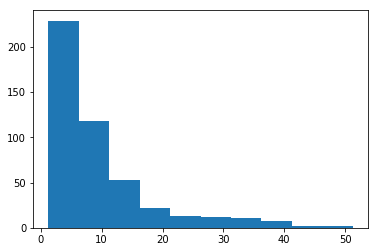

In [51]:
hist(mis_SNR)

(array([2464.,  273.,   47.,   34.,   20.,   11.,    8.,   11.,    5.,
           5.]),
 array([ 0.72876318,  5.82949954, 10.9302359 , 16.03097226, 21.13170862,
        26.23244498, 31.33318134, 36.4339177 , 41.53465406, 46.63539043,
        51.73612679]),
 <a list of 10 Patch objects>)

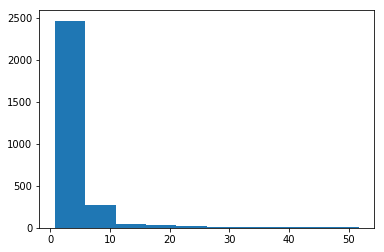

In [52]:
hist(corr_SNR)

In [17]:
FP_orig_types = (FP_table['SNTYPE'].astype('int')).flatten()

In [19]:
FP_distr = []
for a in np.unique(FP_orig_types):
    FP_distr += [(str(a),len(FP_table[FP_orig_types == a]))]
FP_distr

[('-9', 418), ('3', 3), ('22', 1), ('23', 2), ('32', 9), ('33', 9)]

In [20]:
# Seperate misclassified ones by their distinct type

FP_orig_types = (FP_table['SNTYPE'].astype('int')).flatten()
FP_nine = FP_table[FP_orig_types == -9]
FP_non_nine = FP_table[FP_orig_types != -9]
FP_Ibc = FP_table[FP_orig_types == 3]
FP_IIP = FP_table[FP_orig_types == 22]
FP_IIL = FP_table[FP_orig_types == 23]
FP_Ib = FP_table[FP_orig_types == 32]
FP_Ic = FP_table[FP_orig_types == 33]

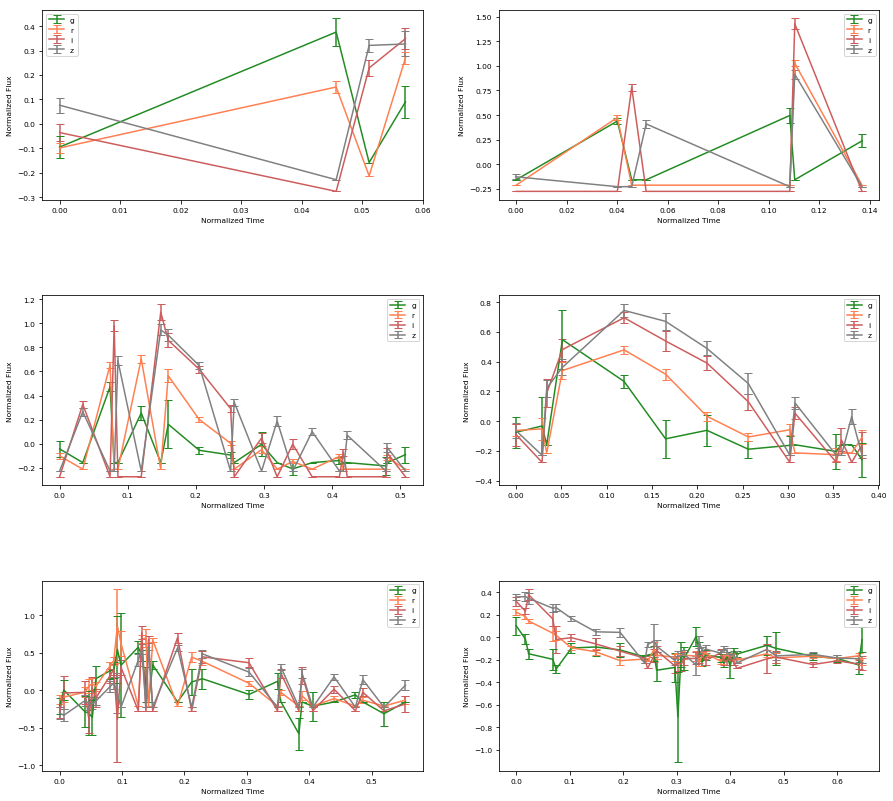

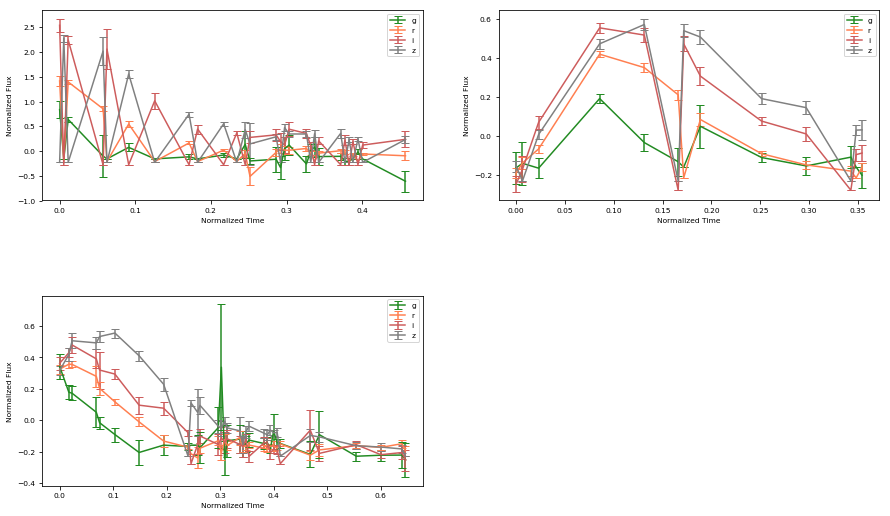

In [30]:
# Make plots for missclassified types

output = FP_Ib # Define which missclassified type to plot

plot_ind = 0
plot_tot = len(output) #for type -9 use a smaller number because there are too many

while plot_ind < plot_tot: 
    plot_num = 321
    fig = plt.figure(figsize=(15, 14))
    for x in range(6):
        plt.rcParams.update({'font.size': 7.5})
        plt.subplot(plot_num)
        plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=None, hspace=0.5)
        
        num_points = output[plot_ind]['num_data_points']-1
        #-1 is temporary and will be removed once the missing point problem is resolved
        MJD = output['DATA'][plot_ind,:num_points,0]
        g_FLUXCAL = output['DATA'][plot_ind,:num_points,1]
        r_FLUXCAL = output['DATA'][plot_ind,:num_points,2]
        i_FLUXCAL = output['DATA'][plot_ind,:num_points,3]
        z_FLUXCAL = output['DATA'][plot_ind,:num_points,4]

        g_err = output['DATA'][plot_ind,:num_points,5]
        r_err = output['DATA'][plot_ind,:num_points,6]
        i_err = output['DATA'][plot_ind,:num_points,7]
        z_err = output['DATA'][plot_ind,:num_points,8]

        plt.errorbar(MJD, g_FLUXCAL, g_err, capsize = 4, label='g',color = 'forestgreen') 
        plt.errorbar(MJD, r_FLUXCAL, r_err, capsize = 4, label='r',color = 'coral')
        plt.errorbar(MJD, i_FLUXCAL, i_err, capsize = 4, label='i', color = 'indianred')
        plt.errorbar(MJD, z_FLUXCAL, z_err, capsize = 4, label='z', color = 'gray')

        plt.xlabel('Normalized Time')
        plt.ylabel('Normalized Flux')
        plt.legend()
        
        plot_num += 1
        plot_ind += 1
        if plot_ind >= plot_tot: break
plt.show()